## Workout Journal Tracker

In [1]:
# Reading an excel file using Python
import xlrd
import datetime
import os
 
# location of the file
loc = ("./journal/workout-plan-daily-journal-tracker.xls")

# output folder
output_directory = os.getcwd() + '/' + 'output'
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)

# open Workbook
wb = xlrd.open_workbook(loc)
sheet_2021 = wb.sheet_by_index(0)
sheet_2022 = wb.sheet_by_index(1)

In [2]:
# importing pandas and setting display.max_rows to None so that it can output the entire DataFrame
import pandas as pd
pd.set_option('display.max_rows', None)

In [3]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8,15)})

In [4]:
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

## Code to read the excel file and skip blanks etc

In [5]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# These cells are skipabble as they are the main headers of each session
cells_to_skip = ['Exercise', 'Weight', 'Grip', 'Amount', 'Rest (s)']
# Both the workout sections and exercises are entered manually as there will be added complexity to what I train
workout_sections = ['Warm-Up', 'Pull', 'Push', 'Legs', 'Weights', 'Floor Routine', 'Bar Routine', 'Pull/Push Pyramid', 'Pull/Push']
exercises = ['Pull-Ups', 'Push-Ups', 'Dips', 'Muscle-Ups', 'L-Sit Pull-Ups', 'Dead Hang (Pull-Up) (s)', 'Plank', 'Hollow Body (s)' 'Squats', 'Lunges', 'Calf Raises', 'Leg Raises', 'Skin The Cat', 'Knee Raises']
current_month = ''
current_week_day = ''
current_day = ''
current_workout_type = ''
current_workout_section = ''
workout_counter = 0
exercise = ''
# Default values for weight and grip, these can be changed as per what I train on any given day
weight = 'Bodyweight'
grip = 'Regular'
amount = 0
rest = 0
counter = 0
temp_list = []
final_list = []
# Default value for deload
deload = 0
# The excel spreadsheet containing the workout journal always follows the same structure, it will not change
# This way we can hardcode some relations between certain values
# Date -> Deload -> Weekday -> Workout Type -> Workout Counter
# Workout Section
# -> Exercise -> Weight -> Grip -> Amount -> Rest (s)
with open('./output/workout_journal_2021.txt', 'w') as f:
    for i in range(1, sheet_2021.nrows):
        for j in range(sheet_2021.ncols):
            current_cell = sheet_2021.cell_value(i, j)
            if(current_cell in months):
                current_month = current_cell
                # print(f"CURRENT_MONTH: {current_month}")
            if(current_cell in weekdays):
                current_week_day = current_cell
                # print(f"CURRENT_WEEK_DAY: {current_week_day}")
                if (sheet_2021.cell_value(i, j-1) == 'Deload'):
                    deload = 1
                else:
                    deload = 0
                current_day = str(datetime.datetime(*xlrd.xldate_as_tuple(sheet_2021.cell_value(i, j-2), wb.datemode)))[:10]
                current_day = current_day[8:10] + current_day[4] + current_day[5:7] + current_day[4] + current_day[0:4]
                # print(f"CURRENT_DAY: {current_day}")
                # skip_float_date = 1
                current_workout_type = sheet_2021.cell_value(i, j+1)
                # print(f"CURRENT_WORKOUT_TYPE: {current_workout_type}")
            if(isinstance(current_cell, str)):
                if('/365' in current_cell):
                    workout_counter = current_cell
                    # print(f"WORKOUT_COUNTER: {workout_counter}")
                if('kg' in current_cell):
                    weight = current_cell
                else:
                    weight = 'Bodyweight'
                if(sheet_2021.cell_value(i, j-1) == weight):
                    grip = current_cell
            if (current_cell != current_month and current_cell != current_week_day and current_cell != current_day and current_cell != workout_counter and current_cell != current_workout_type and current_cell != 'Deload'):
                # Check for length 7 as we want to skip the date cell. We already obtain the value above.
                if(len(str(current_cell)) == 7  and sheet_2021.cell_value(i, j+2) in weekdays):
                    # print(f"CURRENT CELL: {current_cell}")
                    continue
                if(current_cell in cells_to_skip):
                    continue
                if(current_cell in workout_sections):
                    current_workout_section = current_cell
                    # print(f"CURRENT SECTION: {current_workout_section}")
                    continue
                if(type(current_cell) == float):
                    current_cell = int(current_cell)
                # Creating an array of arrays with the other cells and append current cell 
                if(current_cell != current_workout_section):
                    if(current_cell == ''):
                        continue
                    else:
                        counter = counter + 1
                        # print(counter, current_cell)
                        if(counter <= 5):
                            temp_list.append(current_cell)
                        if(counter == 5):
                            counter = 0
                            final_list.append([current_month, current_week_day, current_day, deload, workout_counter, current_workout_type, current_workout_section] + temp_list)
                            # print(f"FINAL LIST: {final_list}")
                            temp_list = []
    f.write(str(final_list))

# Creating the dataframe with our list of lists (workouts)

In [6]:
df_2021 = pd.DataFrame(final_list, columns=['Month', 'Weekday', 'Day', 'Deload', 'Number', 'Type', 'Section', 'Exercise', 'Weight', 'Grip', 'Amount', 'Rest'])

In [7]:
df_2021.describe()

,Deload,Amount,Rest
count,2345.000000,2345.000000,2345.000000
mean,0.036247,19.329211,157.611940
std,0.186945,23.675060,203.471815
min,0.000000,1.000000,0.000000
25%,0.000000,8.000000,90.000000
50%,0.000000,10.000000,90.000000
75%,0.000000,15.000000,90.000000
max,1.000000,218.000000,1800.000000


## Create a column with the year for grouping the total amount of reps

In [8]:
df_2021['Year'] = 2021
# Filter out exercises containing Total in their name
mask = df_2021['Exercise'].str.contains('Total', case=False, na=False)
df_2021[~mask].head()

,Month,Weekday,Day,Deload,Number,Type,Section,Exercise,Weight,Grip,Amount,Rest,Year
0,February,Monday,15-02-2021,0,1/365,Reps,Pull,Pull-Ups,Bodyweight,Regular,7,90,2021
1,February,Monday,15-02-2021,0,1/365,Reps,Pull,Pull-Ups,Bodyweight,Wide,6,90,2021
2,February,Monday,15-02-2021,0,1/365,Reps,Pull,Pull-Ups,Bodyweight,Regular,7,90,2021
3,February,Monday,15-02-2021,0,1/365,Reps,Pull,Chin-Ups,Bodyweight,Regular,7,90,2021
4,February,Monday,15-02-2021,0,1/365,Reps,Pull,Chin-Ups,Bodyweight,Close,6,90,2021


## Split by workout type

In [9]:
df_2021_type = df_2021[~mask]
df_2021_type = df_2021_type.drop_duplicates(['Year','Month','Day','Type'])[['Year','Month','Day','Type']]

In [10]:
df_2021_type.head()

,Year,Month,Day,Type
0,2021,February,15-02-2021,Reps
19,2021,February,18-02-2021,Reps
38,2021,February,22-02-2021,Reps
57,2021,February,25-02-2021,Reps
76,2021,March,15-03-2021,Reps


## Split the types by month and count each instance

In [11]:
df_2021_type_month = df_2021_type.groupby(['Year','Month','Type'], as_index=False).agg(type_count=pd.NamedAgg(column='Type', aggfunc='count'))
df_2021_type_month = df_2021_type_month.rename(columns={'type_count': 'TypeCount'})
df_2021_type_month.head()

,Year,Month,Type,TypeCount
0,2021,April,Abs,4
1,2021,April,Legs,2
2,2021,April,Reps,8
3,2021,August,Abs,2
4,2021,August,Legs,1


## Group by to get the total amount of reps per exercise per month

In [12]:
df_2021_sum = df_2021[~mask].groupby(['Year','Month','Exercise'], as_index=False).sum(['Amount'])
df_2021_sum[['Year','Month','Exercise','Amount']].head()

,Year,Month,Exercise,Amount
0,2021,April,Calf Raises (each leg),105
1,2021,April,Chin-Ups,145
2,2021,April,Dead Hang (Chin-Up) (s),235
3,2021,April,Dead Hang (Pull-Up) (s),560
4,2021,April,Dips,679


In [13]:
df_2021_sum.head()

,Year,Month,Exercise,Deload,Amount,Rest
0,2021,April,Calf Raises (each leg),0,105,630
1,2021,April,Chin-Ups,0,145,1830
2,2021,April,Dead Hang (Chin-Up) (s),0,235,750
3,2021,April,Dead Hang (Pull-Up) (s),0,560,1740
4,2021,April,Dips,0,679,5790


## Split by month

In [14]:
df_2021_sum_february = df_2021_sum[df_2021_sum['Month'] == 'February']
df_2021_sum_march = df_2021_sum[df_2021_sum['Month'] == 'March']
df_2021_sum_april = df_2021_sum[df_2021_sum['Month'] == 'April']
df_2021_sum_may = df_2021_sum[df_2021_sum['Month'] == 'May']
df_2021_sum_june = df_2021_sum[df_2021_sum['Month'] == 'June']
df_2021_sum_july = df_2021_sum[df_2021_sum['Month'] == 'July']
df_2021_sum_august = df_2021_sum[df_2021_sum['Month'] == 'August']
df_2021_sum_september = df_2021_sum[df_2021_sum['Month'] == 'September']
df_2021_sum_october = df_2021_sum[df_2021_sum['Month'] == 'October']
df_2021_sum_november = df_2021_sum[df_2021_sum['Month'] == 'November']
df_2021_sum_december = df_2021_sum[df_2021_sum['Month'] == 'December']

## Group by year

In [15]:
df_2021_year = df_2021_sum.groupby(['Year','Exercise'], as_index=False).sum(['Amount'])

In [16]:
df_2021_year.head()

,Year,Exercise,Deload,Amount,Rest
0,2021,10 Pull-Ups + 10s/10s/10s,0,2,270
1,2021,10 Pull-Ups + 10s/10s/10s + 1,0,1,180
2,2021,10 Pull-Ups + 5s/5s/5s,0,1,180
3,2021,5 Pull-Ups + 5s/5s/5s,0,5,690
4,2021,Australian Pull-Ups,12,450,4050


## Seaborn scatterplot

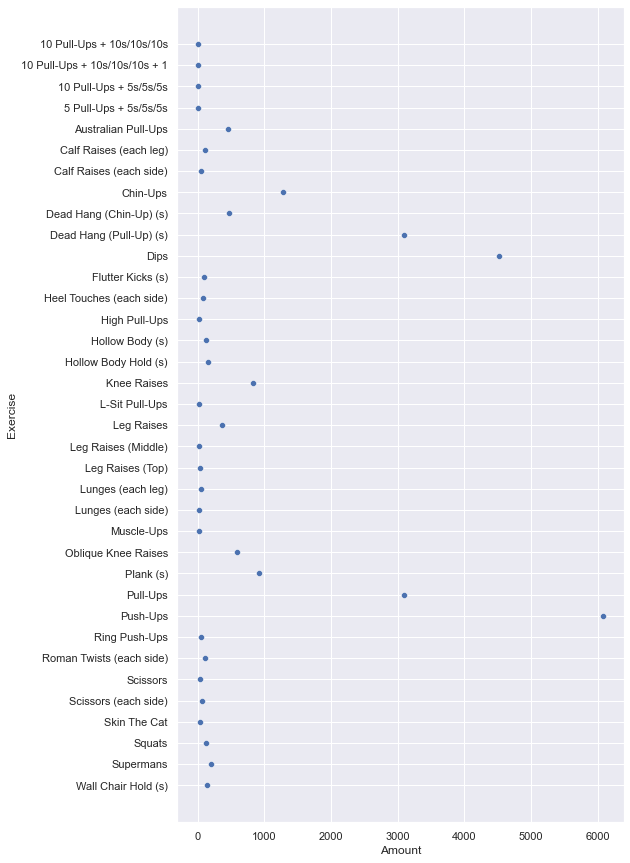

In [17]:
graph = sns.scatterplot(y='Exercise', x='Amount', data=df_2021_year)

## Bokeh configuration for scatterplot

In [18]:
p = figure(title="Reps by Exercise in 2021", x_axis_label='Amount', y_axis_label='Exercise', plot_width = 700, plot_height = 700, y_range=df_2021_year['Exercise'])
p.circle('Amount', 'Exercise', size=10, source=df_2021_year)
# show(p)

GlyphRenderer(id='1039', ...)

# Same process but for 2022 (second sheet in the workbook)

In [19]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# These cells are skipabble as they are the main headers of each session
cells_to_skip = ['Exercise', 'Weight', 'Grip', 'Amount', 'Rest (s)']
# Both the workout sections and exercises are entered manually as there will be added complexity to what I train
workout_sections = ['Warm-Up', 'Pull', 'Push', 'Legs', 'Weights', 'Floor Routine', 'Bar Routine', 'Pull/Push Pyramid', 'Pull/Push']
exercises = ['Pull-Ups', 'Push-Ups', 'Dips', 'Muscle-Ups', 'L-Sit Pull-Ups', 'Dead Hang (Pull-Up) (s)', 'Plank', 'Hollow Body (s)' 'Squats', 'Lunges', 'Calf Raises', 'Leg Raises', 'Skin The Cat', 'Knee Raises']
current_month = ''
current_week_day = ''
current_day = ''
current_workout_type = ''
current_workout_section = ''
workout_counter = 0
exercise = ''
# Default values for weight and grip, these can be changed as per what I train on any given day
weight = 'Bodyweight'
grip = 'Regular'
amount = 0
rest = 0
counter = 0
temp_list = []
final_list = []
# Default value for deload
deload = 0
# The excel spreadsheet containing the workout journal always follows the same structure, it will not change
# This way we can hardcode some relations between certain values
# Date -> Deload -> Weekday -> Workout Type -> Workout Counter
# Workout Section
# -> Exercise -> Weight -> Grip -> Amount -> Rest (s)
with open('./output/workout_journal_2022.txt', 'w') as f:
    for i in range(1, sheet_2022.nrows):
        for j in range(sheet_2022.ncols):
            current_cell = sheet_2022.cell_value(i, j)
            if(current_cell in months):
                current_month = current_cell
                # print(f"CURRENT_MONTH: {current_month}")
            if(current_cell in weekdays):
                current_week_day = current_cell
                # print(f"CURRENT_WEEK_DAY: {current_week_day}")
                if (sheet_2022.cell_value(i, j-1) == 'Deload'):
                    deload = 1
                else:
                    deload = 0
                current_day = str(datetime.datetime(*xlrd.xldate_as_tuple(sheet_2022.cell_value(i, j-2), wb.datemode)))[:10]
                current_day = current_day[8:10] + current_day[4] + current_day[5:7] + current_day[4] + current_day[0:4]
                # print(f"CURRENT_DAY: {current_day}")
                skip_float_date = 1
                current_workout_type = sheet_2022.cell_value(i, j+1)
                # print(f"CURRENT_WORKOUT_TYPE: {current_workout_type}")
            if(isinstance(current_cell, str)):
                if('/365' in current_cell):
                    workout_counter = current_cell
                    # print(f"WORKOUT_COUNTER: {workout_counter}")
                if('kg' in current_cell):
                    weight = current_cell
                else:
                    weight = 'Bodyweight'
                if(sheet_2022.cell_value(i, j-1) == weight):
                    grip = current_cell
            if (current_cell != current_month and current_cell != current_week_day and current_cell != current_day and current_cell != workout_counter and current_cell != current_workout_type and current_cell != 'Deload'):
                # Check for length 7 as we want to skip the date cell. We already obtain the value above.                
                if(len(str(current_cell)) == 7  and sheet_2022.cell_value(i, j+2) in weekdays):
                    continue
                if(current_cell in cells_to_skip):
                    continue
                if(current_cell in workout_sections):
                    current_workout_section = current_cell
                    # print(f"CURRENT SECTION: {current_workout_section}")
                    continue
                if(type(current_cell) == float):
                    current_cell = int(current_cell)
                # Creating an array of arrays with the other cells and append current cell
                if(current_cell != current_workout_section):
                    if(current_cell == ''):
                        continue
                    else:
                        counter = counter + 1
                        # print(counter, current_cell)
                        if(counter <= 5):
                            temp_list.append(current_cell)
                        if(counter == 5):
                            counter = 0
                            final_list.append([current_month, current_week_day, current_day, deload, workout_counter, current_workout_type, current_workout_section] + temp_list)
                            # print(f"FINAL LIST: {final_list}")
                            temp_list = []
    f.write(str(final_list))

# Creating the dataframe with our list of lists (workouts)

In [20]:
df_2022 = pd.DataFrame(final_list, columns=['Month', 'Weekday', 'Day', 'Deload', 'Number', 'Type', 'Section', 'Exercise', 'Weight', 'Grip', 'Amount', 'Rest'])
df_2022.head()

,Month,Weekday,Day,Deload,Number,Type,Section,Exercise,Weight,Grip,Amount,Rest
0,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Pull-Ups,Bodyweight,Regular,4,90
1,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Chin-Ups,Bodyweight,Regular,4,90
2,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Pull-Ups,Bodyweight,Neutral,4,90
3,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Pull-Ups,Bodyweight,Regular,4,90
4,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Chin-Ups,Bodyweight,Regular,4,90


## Create a column with the year for grouping the total amount of reps

In [21]:
df_2022['Year'] = 2022
# Filter out the ones with Total in their name
mask = df_2022['Exercise'].str.contains('Total', case=False, na=False)
df_2022[~mask].head()

,Month,Weekday,Day,Deload,Number,Type,Section,Exercise,Weight,Grip,Amount,Rest,Year
0,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Pull-Ups,Bodyweight,Regular,4,90,2022
1,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Chin-Ups,Bodyweight,Regular,4,90,2022
2,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Pull-Ups,Bodyweight,Neutral,4,90,2022
3,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Pull-Ups,Bodyweight,Regular,4,90,2022
4,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Chin-Ups,Bodyweight,Regular,4,90,2022


## Concatenate the columns Exercise and Weight, for improved grouping

In [22]:
cols = ['Exercise', 'Weight']
df_2022['Exercise_Weight'] = df_2022[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df_2022.head()

,Month,Weekday,Day,Deload,Number,Type,Section,Exercise,Weight,Grip,Amount,Rest,Year,Exercise_Weight
0,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Pull-Ups,Bodyweight,Regular,4,90,2022,Pull-Ups Bodyweight
1,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Chin-Ups,Bodyweight,Regular,4,90,2022,Chin-Ups Bodyweight
2,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Pull-Ups,Bodyweight,Neutral,4,90,2022,Pull-Ups Bodyweight
3,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Pull-Ups,Bodyweight,Regular,4,90,2022,Pull-Ups Bodyweight
4,January,Monday,10-01-2022,0,1/365,Reps,Warm-Up,Chin-Ups,Bodyweight,Regular,4,90,2022,Chin-Ups Bodyweight


## Group by to get the total amount of reps per exercise per month

In [23]:
df_2022_sum = df_2022[~mask].groupby(['Year','Month','Exercise_Weight'], as_index=False)['Amount'].sum()
df_2022_sum.head()

,Year,Month,Exercise_Weight,Amount
0,2022,April,Australian Pull-Ups Bodyweight,160
1,2022,April,Chin-Ups 12kg / 26lbs,18
2,2022,April,Chin-Ups 15kg / 33lbs,40
3,2022,April,Chin-Ups 30kg / 66lbs,26
4,2022,April,Chin-Ups Bodyweight,194


In [24]:
df_2022_sum = df_2022[~mask].groupby(['Year','Month','Exercise_Weight'], as_index=False)['Amount'].sum()
df_2022_sum = df_2022_sum[['Year','Month','Exercise_Weight', 'Amount']]
df_2022_sum.head()

,Year,Month,Exercise_Weight,Amount
0,2022,April,Australian Pull-Ups Bodyweight,160
1,2022,April,Chin-Ups 12kg / 26lbs,18
2,2022,April,Chin-Ups 15kg / 33lbs,40
3,2022,April,Chin-Ups 30kg / 66lbs,26
4,2022,April,Chin-Ups Bodyweight,194


## Split the data by month

In [25]:
df_2022_sum_january = df_2022_sum[df_2022_sum['Month'] == 'January']
df_2022_sum_february = df_2022_sum[df_2022_sum['Month'] == 'February']
df_2022_sum_march = df_2022_sum[df_2022_sum['Month'] == 'March']
df_2022_sum_april = df_2022_sum[df_2022_sum['Month'] == 'April']
df_2022_sum_may = df_2022_sum[df_2022_sum['Month'] == 'May']
df_2022_sum_june = df_2022_sum[df_2022_sum['Month'] == 'June']
df_2022_sum_july = df_2022_sum[df_2022_sum['Month'] == 'July']
df_2022_sum_august = df_2022_sum[df_2022_sum['Month'] == 'August']
df_2022_sum_september = df_2022_sum[df_2022_sum['Month'] == 'September']
df_2022_sum_october = df_2022_sum[df_2022_sum['Month'] == 'October']

In [26]:
df_2022_sum_april.head()

,Year,Month,Exercise_Weight,Amount
0,2022,April,Australian Pull-Ups Bodyweight,160
1,2022,April,Chin-Ups 12kg / 26lbs,18
2,2022,April,Chin-Ups 15kg / 33lbs,40
3,2022,April,Chin-Ups 30kg / 66lbs,26
4,2022,April,Chin-Ups Bodyweight,194


In [27]:
df_2022_sum_may.head()

,Year,Month,Exercise_Weight,Amount
166,2022,May,10 Pull-Ups + 5s/5s/5s Bodyweight,2
167,2022,May,10 Pull-Ups + 7s/7s/7s Bodyweight,1
168,2022,May,5 Pull-Ups + 5s/5s/5s Bodyweight,2
169,2022,May,Australian Pull-Ups Bodyweight,120
170,2022,May,Back Lever (s) Bodyweight,11


In [28]:
df_2022_sum_june.head()

,Year,Month,Exercise_Weight,Amount
124,2022,June,10 Pull-Ups + 5s/5s/5s + 1 Bodyweight,1
125,2022,June,10 Pull-Ups + 5s/5s/5s Bodyweight,1
126,2022,June,10 Pull-Ups + 7s/7s/7s Bodyweight,1
127,2022,June,Australian Pull-Ups Bodyweight,346
128,2022,June,Back Lever (s) Bodyweight,5


In [29]:
df_2022_sum_july.head()

,Year,Month,Exercise_Weight,Amount
90,2022,July,10 Pull-Ups + 10s/10s/10s Bodyweight,1
91,2022,July,5 Pull-Ups + 5s/5s/5s Bodyweight,3
92,2022,July,Advanced Tuck Front Lever (s) Bodyweight,79
93,2022,July,Australian Pull-Ups Bodyweight,290
94,2022,July,Chin-Ups 15kg / 33lbs,15


In [30]:
df_2022_sum_august.head()

,Year,Month,Exercise_Weight,Amount
22,2022,August,10 Pull-Ups + 10s/10s/10s + 1 Bodyweight,2
23,2022,August,10 Pull-Ups + 5s/5s/5s Bodyweight,1
24,2022,August,10 Pull-Ups + 7s/7s/7s Bodyweight,1
25,2022,August,5 Pull-Ups + 5s/5s/5s Bodyweight,1
26,2022,August,Australian Pull-Ups Bodyweight,154


In [31]:
df_2022_sum_september.head()

,Year,Month,Exercise_Weight,Amount
224,2022,September,10 Pull-Ups + 10s/10s/10s + 3 Bodyweight,1
225,2022,September,10 Pull-Ups + 10s/10s/10s + 4 Bodyweight,1
226,2022,September,10 Pull-Ups + 5s/5s/5s Bodyweight,1
227,2022,September,5 Pull-Ups + 5s/5s/5s Bodyweight,3
228,2022,September,Chin-Ups 20kg / 44lbs,45


In [32]:
df_2022_sum_october.head()

,Year,Month,Exercise_Weight,Amount
211,2022,October,10 Pull-Ups + 10s/10s/10s + 1 Bodyweight,3
212,2022,October,10 Pull-Ups + 10s/10s/10s + 3 Bodyweight,1
213,2022,October,5 Pull-Ups + 5s/5s/5s Bodyweight,1
214,2022,October,Chin-Ups 20kg / 44lbs,85
215,2022,October,Chin-Ups 25kg / 55lbs,15


## Group by Year and Exercise_Weight

In [33]:
df_2022_year = df_2022_sum.groupby(['Year','Exercise_Weight'], as_index=False)['Amount'].sum()
df_2022_year.head()

,Year,Exercise_Weight,Amount
0,2022,10 Pull-Ups + 10s/10s/10s + 1 Bodyweight,5
1,2022,10 Pull-Ups + 10s/10s/10s + 3 Bodyweight,2
2,2022,10 Pull-Ups + 10s/10s/10s + 4 Bodyweight,1
3,2022,10 Pull-Ups + 10s/10s/10s Bodyweight,2
4,2022,10 Pull-Ups + 5s/5s/5s + 1 Bodyweight,1


## Configuration for Bokeh scatterplot

In [34]:
TOOLTIPS = HoverTool(tooltips=[
    ("(Amount, Exercise_Weight)", "(@Amount, @Exercise_Weight)")
])

In [35]:
p = figure(title="Reps by Exercise in 2022", x_axis_label='Amount', y_axis_label='Exercise_Weight', plot_width = 700, plot_height = 1000, y_range=df_2022_year['Exercise_Weight'], tools=[TOOLTIPS])
p.circle('Amount', 'Exercise_Weight', size=10, source=df_2022_year)

GlyphRenderer(id='1069', ...)

In [36]:
show(p)

In [37]:
df_2022_year.head()

,Year,Exercise_Weight,Amount
0,2022,10 Pull-Ups + 10s/10s/10s + 1 Bodyweight,5
1,2022,10 Pull-Ups + 10s/10s/10s + 3 Bodyweight,2
2,2022,10 Pull-Ups + 10s/10s/10s + 4 Bodyweight,1
3,2022,10 Pull-Ups + 10s/10s/10s Bodyweight,2
4,2022,10 Pull-Ups + 5s/5s/5s + 1 Bodyweight,1


## Configuration for Seaborn

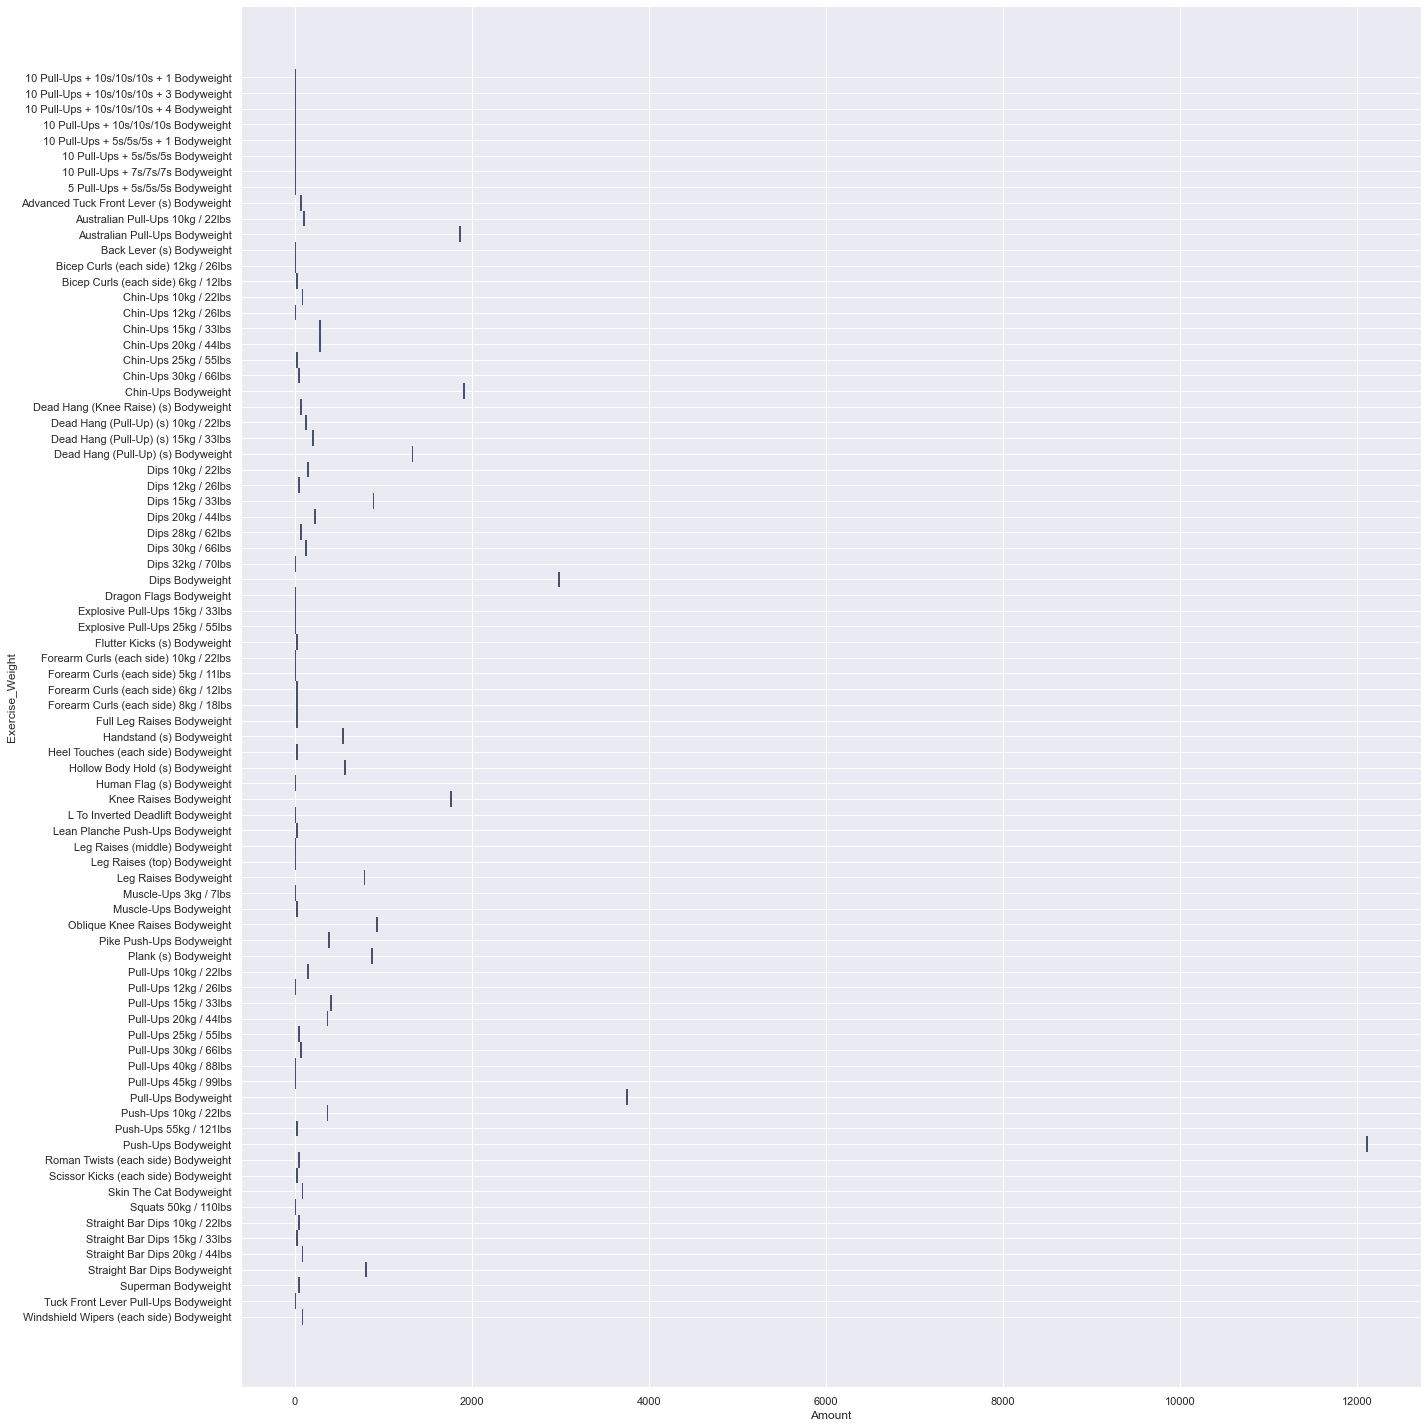

In [38]:
# sns.set_theme(style="darkgrid")
sns.displot(
    df_2022_year, x="Amount", y="Exercise_Weight",
    binwidth=20, height=20, facet_kws=dict(margin_titles=True),
)

Text(0.5, 1.0, 'Total Amount of Reps per Exercise')

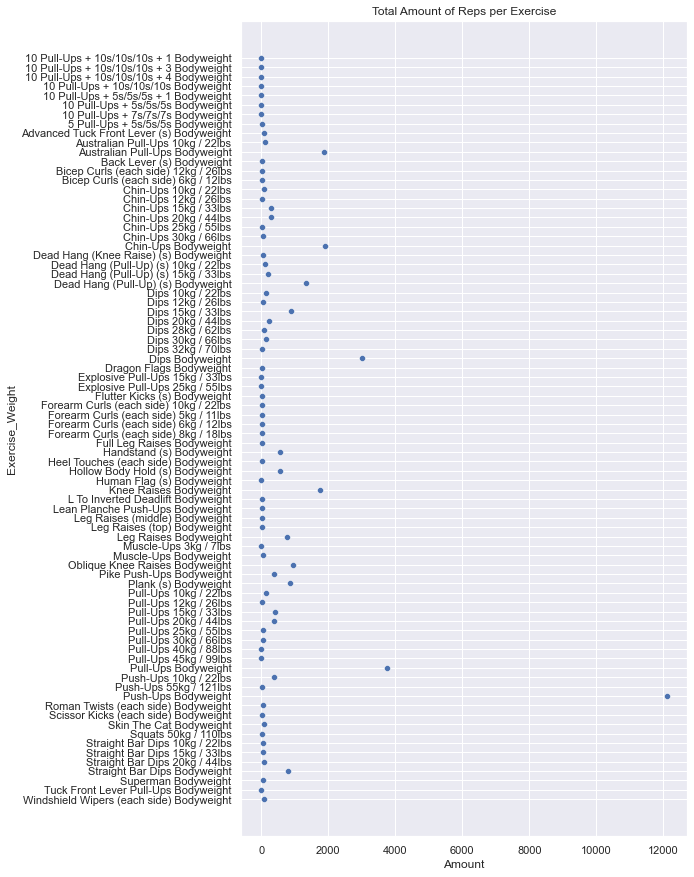

In [39]:
sns.scatterplot(x = "Amount",
                y = "Exercise_Weight", data = df_2022_year).set_title("Total Amount of Reps per Exercise")

## Filter out exercises under 100 total reps

In [40]:
df_2022_year_high = df_2022_year[df_2022_year['Amount'] > 100]

In [41]:
df_2022_year_high.head()

,Year,Exercise_Weight,Amount
9,2022,Australian Pull-Ups 10kg / 22lbs,120
10,2022,Australian Pull-Ups Bodyweight,1870
16,2022,Chin-Ups 15kg / 33lbs,285
17,2022,Chin-Ups 20kg / 44lbs,300
20,2022,Chin-Ups Bodyweight,1902


In [42]:
df_2022_year_high

,Year,Exercise_Weight,Amount
9,2022,Australian Pull-Ups 10kg / 22lbs,120
10,2022,Australian Pull-Ups Bodyweight,1870
16,2022,Chin-Ups 15kg / 33lbs,285
17,2022,Chin-Ups 20kg / 44lbs,300
20,2022,Chin-Ups Bodyweight,1902
22,2022,Dead Hang (Pull-Up) (s) 10kg / 22lbs,125
23,2022,Dead Hang (Pull-Up) (s) 15kg / 33lbs,210
24,2022,Dead Hang (Pull-Up) (s) Bodyweight,1335
25,2022,Dips 10kg / 22lbs,152
27,2022,Dips 15kg / 33lbs,884


<AxesSubplot:ylabel='Exercise_Weight'>

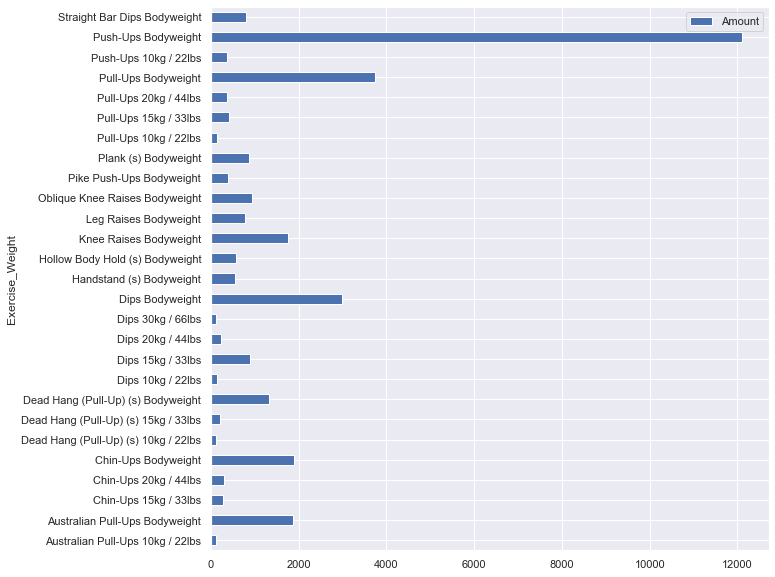

In [43]:
df_2022_year_high.plot.barh(x='Exercise_Weight', y='Amount', rot=0, figsize=(10,10))